In [1]:
import numpy as np
import os, sys, re
import astropy
from astropy.io import fits
from astropy.io.votable import writeto as writetoVO
from astropy.table import Table, Column
from astropy.io.votable import parse_single_table
from argparse import ArgumentParser
import matplotlib.pyplot as plt
from matplotlib import markers
from matplotlib.pyplot import axes
import matplotlib
import pandas as pd
import glob
import astroquery
import astropy.units as u
import math
from astropy.wcs import WCS
import scipy
import urllib.request
import json

In [2]:
#Setting the background colour for output plots
plt.rcParams['savefig.facecolor'] = "1"

In [3]:
# Importing the getobsid thing.
BASEURL = 'http://ws.mwatelescope.org/'

def getmeta(servicetype='metadata', service='obs', params=None): 
    """Given a JSON web servicetype ('observation' or 'metadata'), a service name (eg 'obs', find, or 'con')
       and a set of parameters as a Python dictionary, return a Python dictionary containing the result.
    """
    if params:
        # Turn the dictionary into a string with encoded 'name=value' pairs
        data = urllib.parse.urlencode(params)
    else:
        data = ''
    
    # Get the data 
    try: 
        result = json.load(urllib.request.urlopen(BASEURL + servicetype + '/' + service + '?' + data)) 
    except urllib.error.HTTPError as err: 
        print("HTTP error from server: code=%d, response:\n %s" % (err.code, err.read())) 
        return
    except urllib.error.URLError as err: 
        print("URL or network error: %s" % err.reason)
        return 

    # Return the result dictionary 
    return result

In [4]:
# def ionosphere_analyser(direc='/home/brandon/PHD/Data/ionosphere/all_2/',obsid_key='./Obsid_key.csv',ns_cat_location='/home/brandon/PHD/Data/ionosphere/NVSS_SUMSS_psfcal.fits',night='all'):

In [5]:
direc='/home/brandon/PHD/Data/ionosphere/test/'
obsid_key='./Obsid_key.csv'
night='all'
ns_cat_path='/home/brandon/PHD/Data/ionosphere/NVSS_SUMSS_psfcal.fits'
ns_cat_cut_type=None
ns_cat_cut_level=0.2
source_radius=0.5
GLEAM_X_cut_type='suggested'
GLEAM_x_cut_level_int_rms=2
GLEAM_x_cut_level_int_peak=2
GLEAM_X_SNR=5

In [6]:

#Initial dict defs
Field_numbers_GLEAM_X_obsids=dict()
obsids=dict()
Dataframes_GLEAM_X_obsids=dict()
Fits_files_GLEAM_X_obsids=dict()
Skycoords_GLEAM_X_obsids=dict()
nights_GLEAM_X_obsids=dict()


#Night targeting

obsid_keys=pd.read_csv(obsid_key,index_col=0)
if night!='all':
    first_obsid=obsid_keys.loc[night,'First Obsid']
    last_obsid=obsid_keys.loc[night,'Last Obsid']
    olist = getmeta(service='find', params={'projectid':'G0008','mintime':first_obsid,'maxtime':last_obsid,'anychan':72,'pagesize':1000000,'minduration':120})
    olist_pandas=pd.DataFrame(olist)
    obsids_list=olist_pandas.iloc[:,0]
    for i in range(0,len(obsids_list)):
        obsids[i]=obsids_list.iloc[i]
        nights_GLEAM_X_obsids[i]=night
    
    
else:
    inputs_GLEAM_X_obsids=glob.glob(direc+'*rescaled_comp.fits')
    
    #for testing
    # inputs_GLEAM_X_obsids=inputs_GLEAM_X_obsids[:100]

    inputs_GLEAM_X_obsids=inputs_GLEAM_X_obsids
    for i in range(0,len(inputs_GLEAM_X_obsids)):
        obsids[i]=int(inputs_GLEAM_X_obsids[i][-52:-42])
        mask=(obsid_keys['First Obsid']<= obsids[i]) & (obsid_keys['Last Obsid']>=obsids[i])
        nights_GLEAM_X_obsids[i]=obsid_keys[mask].index[0]



#making_the_GLEAM_X_obsids_dataframes.
for i in range(0,len(obsids)):
        try:
            Fits_files_GLEAM_X_obsids[i]=fits.open(direc+str(obsids[i])+'_deep-MFS-image-pb_warp_rescaled_comp.fits')
            Dataframes_GLEAM_X_obsids[i]=pd.DataFrame(Fits_files_GLEAM_X_obsids[i][1].data)
            Dataframes_GLEAM_X_obsids[i].dropna(axis=0,how='any',subset=['ra','dec'],inplace=True)

            #GLEAM-X cutting.
            #Suggested cut.
            if GLEAM_X_cut_type=='suggested':
                Dataframes_GLEAM_X_obsids[i]['int_peak_comparison_div']=Dataframes_GLEAM_X_obsids[i]['int_flux']/Dataframes_GLEAM_X_obsids[i]['peak_flux']
                Dataframes_GLEAM_X_obsids[i]['int_err_rms_comparison_div']=Dataframes_GLEAM_X_obsids[i]['err_int_flux']/Dataframes_GLEAM_X_obsids[i]['local_rms']
                mask=(Dataframes_GLEAM_X_obsids[i]['int_peak_comparison_div']<=GLEAM_x_cut_level_int_rms) & (Dataframes_GLEAM_X_obsids[i]['int_err_rms_comparison_div']<=GLEAM_x_cut_level_int_rms)
                Dataframes_GLEAM_X_obsids[i]=Dataframes_GLEAM_X_obsids[i][mask]
                Dataframes_GLEAM_X_obsids[i].drop(columns=['int_peak_comparison_div','int_err_rms_comparison_div'],inplace=True)
            
            #Basic.
            if GLEAM_X_cut_type=='basic':
                Dataframes_GLEAM_X_obsids[i]['SNR']=Dataframes_GLEAM_X_obsids[i]['int_flux']/Dataframes_GLEAM_X_obsids[i]['local_rms']
                Dataframes_GLEAM_X_obsids[i]['int_peak_comparison_div']=Dataframes_GLEAM_X_obsids[i]['int_flux']/Dataframes_GLEAM_X_obsids[i]['peak_flux']
                mask=(Dataframes_GLEAM_X_obsids[i]['int_peak_comparison_div']<=GLEAM_x_cut_level_int_rms) & (Dataframes_GLEAM_X_obsids[i]['SNR']>=GLEAM_X_SNR)
                Dataframes_GLEAM_X_obsids[i]=Dataframes_GLEAM_X_obsids[i][mask]
                Dataframes_GLEAM_X_obsids[i].drop(columns=['int_peak_comparison_div','SNR'],inplace=True)

                
            # Dataframes_GLEAM_X_obsids[i]['int_err_rms_comparison_div']=Dataframes_GLEAM_X_obsids[i]['err_int_flux']/Dataframes_GLEAM_X_obsids[i]['local_rms']
            
            #Other processing.
            Skycoords_GLEAM_X_obsids[i]=astropy.coordinates.SkyCoord(Dataframes_GLEAM_X_obsids[i].ra,Dataframes_GLEAM_X_obsids[i].dec,frame='fk5',unit=u.deg)
            Dataframes_GLEAM_X_obsids[i].reset_index(drop=True,inplace=True)
            Dataframes_GLEAM_X_obsids[i]['night']=nights_GLEAM_X_obsids[i]
        except:
            del obsids[i]


#Reseting the dict keys. Remember to ask about the wierd missing files.

obsids=dict((i,obsids[k]) for i,k in enumerate(sorted(obsids.keys())))
Fits_files_GLEAM_X_obsids=dict((i,Fits_files_GLEAM_X_obsids[k]) for i,k in enumerate(sorted(Fits_files_GLEAM_X_obsids.keys())))
Dataframes_GLEAM_X_obsids=dict((i,Dataframes_GLEAM_X_obsids[k]) for i,k in enumerate(sorted(Dataframes_GLEAM_X_obsids.keys())))
Skycoords_GLEAM_X_obsids=dict((i,Skycoords_GLEAM_X_obsids[k]) for i,k in enumerate(sorted(Skycoords_GLEAM_X_obsids.keys())))
nights_GLEAM_X_obsids=dict((i,nights_GLEAM_X_obsids[k]) for i,k in enumerate(sorted(nights_GLEAM_X_obsids.keys())))

In [7]:
#ns_cutting. Currently incomplete.
ns_cat=fits.open(ns_cat_path)
ns_cat_DF=pd.DataFrame(ns_cat[1].data)

#basic flux cut on NVSS sources.
if ns_cat_cut_type=='basic':
    ns_cat_DF=ns_cat_DF[ns_cat_DF['int_flux']>=ns_cat_cut_level]

#My initial hacky cut, included for testing purposes.
if ns_cat_cut_type=='hacky':
    mega_dataframe=pd.concat(Dataframes_GLEAM_X_obsids,ignore_index=True)
    mega_dataframe.reset_index(inplace=True,drop=True)
    mega_dataframe.dropna(axis=0,how='any',subset=['ra','dec'],inplace=True)
    mega_skycoord=astropy.coordinates.SkyCoord(mega_dataframe.ra,mega_dataframe.dec,frame='fk5',unit=u.deg)
    ns_skycoord=astropy.coordinates.SkyCoord(ns_cat_DF.RAJ2000,ns_cat_DF.DEJ2000,frame='fk5',unit=u.deg)
    idx1,idx2,sep2d,dist3d=astropy.coordinates.search_around_sky(ns_skycoord,mega_skycoord,1*u.arcmin)
    ns_cat_DF['local_RMS_GLEAM_X']=np.nan
    ns_cat_DF['assumed_GLEAM-X_freq']=np.nan
    for i in range(len(idx1)):
        idx1_index=idx1[i]
        ns_cat_DF.iloc[idx1_index,-1]=np.nanmean(mega_dataframe.iloc[idx2[idx1==idx1_index],:].local_rms)
    ns_cat_DF=ns_cat_DF[ns_cat_DF['peak_flux']/ns_cat_DF['local_RMS_GLEAM_X']>5]

In [8]:
ns_cat_DF

,RAJ2000,DEJ2000,peak_flux,a,b,int_flux,pa
0,0.006897,-0.369403,0.210119,0.012712,0.012598,0.215362,33.798363
1,0.011983,9.951805,0.278477,0.013475,0.012635,0.303457,-2.222824
2,0.012546,87.221134,0.069827,0.013162,0.012715,0.074794,53.353481
3,0.012891,-13.866657,0.060188,0.012881,0.012502,0.062033,-22.920422
4,0.017307,-28.405512,0.080617,0.012648,0.012502,0.081580,-76.841743
...,...,...,...,...,...,...,...
70367,359.915170,-83.028360,0.291500,0.012556,0.012528,0.291500,146.000000
70368,359.922540,-68.571780,0.143400,0.013472,0.012611,0.143600,109.199997
70369,359.977790,-44.002750,0.080700,0.018000,0.013194,0.083400,107.000000
70370,359.988790,-41.546810,0.110200,0.020167,0.015278,0.130400,19.299999


In [9]:
#Pre-match: cutting down the dataframes to only the subsample of ns sources.
ns_cat_DF_skycoord=astropy.coordinates.SkyCoord(ns_cat_DF.RAJ2000,ns_cat_DF.DEJ2000,frame='fk5',unit=u.deg)
for i in range(len(obsids)):
    idx1,idx2,sep2d,dist3d=astropy.coordinates.search_around_sky(ns_cat_DF_skycoord,Skycoords_GLEAM_X_obsids[i],source_radius*u.arcmin)
    if len(idx1)>0:
        Dataframes_GLEAM_X_obsids[i]=Dataframes_GLEAM_X_obsids[i].iloc[idx2,:]
        Dataframes_GLEAM_X_obsids[i].reset_index(drop=True,inplace=True)
        Skycoords_GLEAM_X_obsids[i]=astropy.coordinates.SkyCoord(Dataframes_GLEAM_X_obsids[i].ra,Dataframes_GLEAM_X_obsids[i].dec,frame='fk5',unit=u.deg)
        # Dataframes_GLEAM_X_obsids[i]=Dataframes_GLEAM_X_obsids[i].add_suffix('_'+inputs_GLEAM_X_obsids[i][-52:-42])
        Dataframes_GLEAM_X_obsids[i]['Source_row_no']=np.arange(0,len(Dataframes_GLEAM_X_obsids[i]))
        Dataframes_GLEAM_X_obsids[i]['obs_id']=obsids[i]
        Dataframes_GLEAM_X_obsids[i]['sep_NVSS_GLEAM-X']=sep2d.arcmin
        Dataframes_GLEAM_X_obsids[i]['night']=nights_GLEAM_X_obsids[i]

In [10]:
#Making a mega dataframe
mega_dataframe=pd.concat(Dataframes_GLEAM_X_obsids,ignore_index=True)
mega_dataframe.reset_index(inplace=True,drop=True)
mega_dataframe.dropna(axis=0,how='any',subset=['ra','dec'],inplace=True)
mega_dataframe['blur']=np.log10(mega_dataframe['int_flux']/mega_dataframe['peak_flux'])
mega_skycoord=astropy.coordinates.SkyCoord(mega_dataframe.ra,mega_dataframe.dec,frame='fk5',unit=u.deg)

In [11]:
# mega_dataframe['int_rms_comparison']=mega_dataframe['err_int_flux']/mega_dataframe['local_rms']
# mega_dataframe['int_rms_comparison'].describe()

In [12]:
# mega_dataframe['int_rms_comparison']=mega_dataframe['int_flux']/mega_dataframe['peak_flux']
# mega_dataframe['int_rms_comparison'].describe()

(0.0, 2.546863317489624)

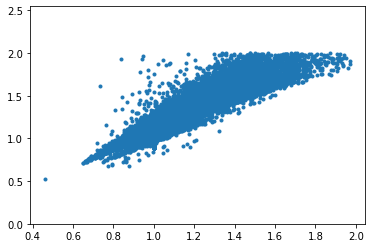

In [13]:
plt.plot(mega_dataframe['int_flux']/mega_dataframe['peak_flux'],mega_dataframe['err_int_flux']/mega_dataframe['local_rms'],marker='.',linestyle='')
plt.ylim(bottom=0)

In [14]:
# #Getting the single source groups.
# idx1,idx2,sep2d,dist3d=astropy.coordinates.search_around_sky(ns_cat_DF_skycoord,mega_skycoord,source_radius*u.arcmin)

# #need to group by idx1 (i.e ns source index): setting up the dict, idx1 values.
# source_info_ns=dict()
# unique_idx1=np.unique(idx1)

# #looping, finding all corresponding idx2 (GLEAM-X) sources per idx1, over all nights included.
# for i in range(len(unique_idx1)):
#     idx1_index=unique_idx1[i]
#     array_index=idx2[idx1==idx1_index]
#     source_info=mega_dataframe.iloc[array_index,:]
#     source_info['mean_flux_source']=np.nanmean(source_info['int_flux'])
#     source_info['norm_diff_frac']=source_info['int_flux']/source_info['mean_flux_source']
#     source_info['log_norm_diff_frac']=np.log10(source_info['int_flux']/source_info['mean_flux_source'])
#     source_info['log_error_diff_frac']=np.log10(source_info['err_int_flux']/source_info['mean_flux_source'])
#     source_info['error_diff_frac']=source_info['err_int_flux']/source_info['mean_flux_source']
#     source_info['std_dev_flux']=np.nanstd(source_info['int_flux'])/source_info['mean_flux_source']
#     source_info['mean_blur_source']=np.nanmean(source_info['blur'])
#     source_info['mean_diff']=np.nanmean(source_info['sep_NVSS_GLEAM-X'])
#     source_info['source']=i
#     source_info['data_points']=len(array_index)
#     source_info['obs_id_int']=source_info['obs_id'].to_numpy(dtype='int64')
#     source_info['mean_diff_weight']=np.sum((source_info['int_flux']/source_info['err_int_flux'])*np.absolute(source_info['int_flux']-source_info['mean_flux_source']))
#     source_info.sort_values(by='obs_id',inplace=True,ascending=True)
#     source_info.reset_index(drop=True,inplace=True)
#     source_info_ns[i]=source_info

In [15]:
# looping, finding all corresponding idx2 (GLEAM-X) sources per idx1, over all nights included.
#Getting the single source groups.
idx1,idx2,sep2d,dist3d=astropy.coordinates.search_around_sky(ns_cat_DF_skycoord,mega_skycoord,source_radius*u.arcmin)

#need to group by idx1 (i.e ns source index): setting up the dict, idx1 values.
unique_idx1=np.unique(idx1)
source_1_night_dataframes=dict()

#looping, finding all corresponding idx2 (GLEAM-X) sources per idx1, over all nights included.
night_index=0
for i in range(len(unique_idx1)):
    idx1_index=unique_idx1[i]
    array_index=idx2[idx1==idx1_index]
    source_info=mega_dataframe.iloc[array_index,:]
    source_info.sort_values(by='obs_id',inplace=True,ascending=True)
    source_info.reset_index(drop=True,inplace=True)
    nights_list=np.unique(source_info['night'])
    
    for j in range(len(nights_list)):
        mask=source_info['night']==nights_list[j]
        nights_dataframe=source_info[mask]

        nights_dataframe['mean_flux_source']=np.nanmean(nights_dataframe['int_flux'])
        nights_dataframe['norm_diff_frac']=nights_dataframe['int_flux']/nights_dataframe['mean_flux_source']
        nights_dataframe['log_norm_diff_frac']=np.log10(nights_dataframe['int_flux']/nights_dataframe['mean_flux_source'])
        nights_dataframe['log_error_diff_frac']=np.log10(nights_dataframe['err_int_flux']/nights_dataframe['mean_flux_source'])
        nights_dataframe['error_diff_frac']=nights_dataframe['err_int_flux']/nights_dataframe['mean_flux_source']
        nights_dataframe['std_dev_flux']=np.nanstd(nights_dataframe['int_flux'])/nights_dataframe['mean_flux_source']
        nights_dataframe['mean_blur_source']=np.nanmean(nights_dataframe['blur'])
        nights_dataframe['mean_diff']=np.nanmean(nights_dataframe['sep_NVSS_GLEAM-X'])
        nights_dataframe['source']=i
        nights_dataframe['data_points']=len(array_index)
        nights_dataframe['obs_id_int']=nights_dataframe['obs_id'].to_numpy(dtype='int64')
        nights_dataframe['mean_diff_weight']=np.sum((nights_dataframe['int_flux']/nights_dataframe['err_int_flux'])*np.absolute(nights_dataframe['int_flux']-nights_dataframe['mean_flux_source']))
        nights_dataframe.sort_values(by=['mean_diff_weight','obs_id_int'],inplace=True,ascending=[False,True])
        nights_dataframe.reset_index(drop=True,inplace=True)
        nights_dataframe['source_night_index']=night_index
        source_1_night_dataframes[night_index]=nights_dataframe
        night_index=night_index+1

/home/brandon/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_14375/2729303154.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nights_dataframe['mean_flux_source']=np.nanmean(nights_dataframe['int_flux'])
/tmp/ipykernel_14375/2729303154.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [16]:
# Making the source based mega dataframe.
mega_dataframe_source_based=pd.concat(source_1_night_dataframes,ignore_index=True)
mega_dataframe_source_based.sort_values(by=['mean_diff_weight','obs_id_int'],inplace=True,ascending=[False,True])
mega_dataframe_source_based.reset_index(drop=True,inplace=True)

In [17]:
source_1_night_dataframes[18]

,island,source,background,local_rms,ra_str,dec_str,ra,err_ra,dec,err_dec,...,log_norm_diff_frac,log_error_diff_frac,error_diff_frac,std_dev_flux,mean_blur_source,mean_diff,data_points,obs_id_int,mean_diff_weight,source_night_index
0,3217,12,0.001874,0.279877,00:00:27.67,-34:52:35.56,0.115284,0.005701,-34.876545,0.002576,...,-0.041472,-0.710669,0.194684,0.080928,0.023955,0.144486,15,1212094056,10.472708,18
1,3928,12,0.000889,0.142063,00:00:29.89,-34:52:22.03,0.124560,0.002057,-34.872787,0.001077,...,0.057589,-1.015027,0.096599,0.080928,0.023955,0.144486,15,1212095256,10.472708,18
2,4872,12,0.001951,0.062737,00:00:29.10,-34:52:24.91,0.121259,0.000807,-34.873585,0.000536,...,0.013362,-1.402802,0.039555,0.080928,0.023955,0.144486,15,1212097360,10.472708,18
3,5307,12,0.003159,0.047374,00:00:28.91,-34:52:22.93,0.120462,0.000633,-34.873035,0.000483,...,-0.017189,-1.516060,0.030475,0.080928,0.023955,0.144486,15,1212098560,10.472708,18
4,5419,12,0.002571,0.038080,00:00:29.36,-34:52:24.09,0.122322,0.000456,-34.873356,0.000386,...,-0.019162,-1.629117,0.023490,0.080928,0.023955,0.144486,15,1212099760,10.472708,18


In [18]:
unique_nights=np.unique(mega_dataframe_source_based['night'])
night=dict()
night_dataframe=dict()
for i in range(len(unique_nights)):
    night[i]=unique_nights[i]
    mask=mega_dataframe_source_based['night']==unique_nights[i]
    night_dataframe[i]=mega_dataframe_source_based[mask]

In [19]:
for i in range(len(night_dataframe)):
    single_night_info_dict={'night':np.unique(night_dataframe[i]['night']),
                    'min_obsid':np.nanmin(night_dataframe[i]['obs_id']),
                    'max_obsid':np.nanmax(night_dataframe[i]['obs_id']),
                    'mean_blur':np.nanmean(night_dataframe[i]['blur']),
                    'min_blur':np.nanmin(night_dataframe[i]['blur']),
                    'max_blur':np.nanmax(night_dataframe[i]['blur']),
                    'mean_rms':np.nanmean(night_dataframe[i]['local_rms']),
                    'mean_sep':np.nanmean(night_dataframe[i]['sep_NVSS_GLEAM-X']),
                    'max_sep':np.nanmax(night_dataframe[i]['sep_NVSS_GLEAM-X']),
                    'std_sep':np.nanstd(night_dataframe[i]['sep_NVSS_GLEAM-X']),
                    'min_frac_flux':np.nanmin(night_dataframe[i]['norm_diff_frac']),
                    'mean_frac_flux':np.nanmean(night_dataframe[i]['norm_diff_frac']),
                    'max_frac_flux':np.nanmax(night_dataframe[i]['norm_diff_frac']),
                    'std_dev_normflux':np.nanmean(night_dataframe[i]['std_dev_flux']),
                    }
    single_night_info_dataframe=pd.DataFrame(single_night_info_dict,index=[0])
    if i==0:
        night_info_df=single_night_info_dataframe
    else:
        night_info_df=pd.concat([night_info_df,single_night_info_dataframe],ignore_index=True)
night_info_df.reindex(night_info_df['night'],copy=False)
night_info_df

,night,min_obsid,max_obsid,mean_blur,min_blur,max_blur,mean_rms,mean_sep,max_sep,std_sep,min_frac_flux,mean_frac_flux,max_frac_flux,std_dev_normflux
0,2018-06-03,1212056856,1212099760,0.018402,-0.148432,0.286540,0.107460,0.207383,0.499999,0.120478,0.306048,1.0,2.279618,0.108481
1,2020-10-01,1285593680,1285620080,0.014482,-0.188861,0.294488,0.102971,0.214941,0.499994,0.125375,0.353981,1.0,2.683861,0.113632
2,2020-10-04,1285846168,1285879768,-0.001183,-0.334461,0.294529,0.163942,0.231239,0.499978,0.127021,0.232067,1.0,2.341688,0.126125


In [20]:
obsids=pd.unique(mega_dataframe_source_based['obs_id_int'])
data_by_obsid=dict()
for i in range(0,len(obsids)):
    obsid=obsids[i]
    mask=mega_dataframe_source_based['obs_id_int']==obsid
    masked_dataframe=mega_dataframe_source_based[mask]
    masked_dataframe.reset_index(drop=True,inplace=True)
    data_by_obsid[i]=masked_dataframe

In [21]:
night_dataframe[0]

,island,source,background,local_rms,ra_str,dec_str,ra,err_ra,dec,err_dec,...,log_norm_diff_frac,log_error_diff_frac,error_diff_frac,std_dev_flux,mean_blur_source,mean_diff,data_points,obs_id_int,mean_diff_weight,source_night_index
39,258,19726,-0.127450,2.188181,21:14:40.54,-25:41:47.43,318.668915,0.004601,-25.696508,0.002031,...,-0.015380,-0.732659,0.185072,0.08558,0.012415,0.121284,15,1212084760,2061.725342,23993
40,323,19726,-0.066666,1.279621,21:14:40.24,-25:41:39.13,318.667664,0.001990,-25.694202,0.001082,...,0.083703,-0.968564,0.107507,0.08558,0.012415,0.121284,15,1212085960,2061.725342,23993
41,521,19726,0.076065,0.729975,21:14:40.16,-25:41:52.13,318.667328,0.001110,-25.697813,0.000708,...,0.052587,-1.230225,0.058854,0.08558,0.012415,0.121284,15,1212087160,2061.725342,23993
42,4340,19726,-0.000872,0.085865,21:14:40.14,-25:41:50.76,318.667236,0.000119,-25.697433,0.000096,...,-0.001246,-2.189566,0.006463,0.08558,0.012415,0.121284,15,1212089256,2061.725342,23993
43,5026,19726,-0.000899,0.064931,21:14:40.31,-25:41:46.20,318.667969,0.000078,-25.696167,0.000071,...,0.020796,-2.322747,0.004756,0.08558,0.012415,0.121284,15,1212090456,2061.725342,23993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179376,906,28792,0.001816,0.077022,23:46:49.67,-50:48:02.59,356.706940,0.004155,-50.800720,0.004279,...,0.000000,-0.705711,0.196920,0.00000,0.140029,0.245724,4,1212099760,0.000000,37661
179377,845,28798,0.000353,0.079923,23:47:18.78,-51:10:35.87,356.828247,0.003654,-51.176632,0.003378,...,0.000000,-0.708717,0.195561,0.00000,-0.030531,0.143510,2,1212099760,0.000000,37673
179378,912,28820,0.005894,0.077895,23:50:28.52,-50:42:56.98,357.618835,0.004048,-50.715828,0.003156,...,0.000000,-0.712538,0.193848,0.00000,0.050718,0.205465,3,1212099760,0.000000,37714
179379,1344,28846,0.002905,0.060816,23:54:15.40,-48:12:59.10,358.564178,0.004419,-48.216415,0.003244,...,0.000000,-0.676351,0.210692,0.00000,0.011327,0.488756,3,1212099760,0.000000,37763
